<a href="https://colab.research.google.com/github/mikethisyamondol/company_bankruptcy_prediction/blob/main/company_bankruptcy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Company Bankruptcy Prediction
<br>
<br>
Mike Thisyamondol

#### Ingest

In [1]:
from IPython.display import clear_output

In [2]:
! pip install shap
! pip install eli5
clear_output()

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures 
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
import scipy.stats as stats
from sklearn.metrics import recall_score, confusion_matrix, classification_report, accuracy_score, recall_score, precision_score, f1_score, roc_curve, auc
from sklearn.feature_selection import SelectKBest, f_classif
from operator import itemgetter
import pickle

import shap
import eli5
import zipfile

%matplotlib inline

In [4]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1Hqs_GVKEqC24F_Ieth0wlV7DM6BTmUS0' -O kaggle.json.zip

clear_output()

In [5]:
with zipfile.ZipFile('kaggle.json.zip', 'r') as zip_ref:
    zip_ref.extractall('kaggle.json')

In [6]:
! pip install kaggle
clear_output()

In [7]:
! mkdir ~/.kaggle

In [8]:
! cp ./kaggle.json/kaggle.json ~/.kaggle/

In [9]:
! chmod 600 ~/.kaggle/kaggle.json

In [10]:
! kaggle datasets download fedesoriano/company-bankruptcy-prediction

  0% 0.00/4.63M [00:00<?, ?B/s]
100% 4.63M/4.63M [00:00<00:00, 74.9MB/s]


In [11]:
with zipfile.ZipFile('./company-bankruptcy-prediction.zip', 'r') as zip_ref:
    zip_ref.extractall('company_bankruptcy_preciction')

In [12]:
df = pd.read_csv('./company_bankruptcy_preciction/data.csv')

In [13]:
df.head()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Cash Flow Per Share,Revenue Per Share (Yuan ¥),Operating Profit Per Share (Yuan ¥),Per Share Net profit before tax (Yuan ¥),Realized Sales Gross Profit Growth Rate,Operating Profit Growth Rate,After-tax Net Profit Growth Rate,Regular Net Profit Growth Rate,Continuous Net Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Total Asset Return Growth Rate Ratio,Cash Reinvestment %,Current Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,Debt ratio %,Net worth/Assets,Long-term fund suitability ratio (A),...,Current Assets/Total Assets,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Current Liability to Assets,Operating Funds to Liability,Inventory/Working Capital,Inventory/Current Liability,Current Liabilities/Liability,Working Capital/Equity,Current Liabilities/Equity,Long-term Liability to Current Assets,Retained Earnings to Total Assets,Total income/Total expense,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Working capitcal Turnover Rate,Cash Turnover Rate,Cash Flow to Sales,Fixed Assets to Assets,Current Liability to Liability,Current Liability to Equity,Equity to Long-term Liability,Cash Flow to Total Assets,Cash Flow to Liability,CFO to Assets,Cash Flow to Equity,Current Liability to Current Assets,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,0.780985,1.256969e-04,0.0,0.458143,0.000725,0.0,0.147950,0.147950,0.147950,0.169141,0.311664,0.017560,0.095921,0.138736,0.022102,0.848195,0.688979,0.688979,0.217535,4.980000e+09,0.000327,0.263100,0.363725,0.002259,0.001208,0.629951,0.021266,0.207576,0.792424,0.005024,...,0.190643,0.004094,0.001997,1.473360e-04,0.147308,0.334015,0.276920,0.001036,0.676269,0.721275,0.339077,0.025592,0.903225,0.002022,0.064856,7.010000e+08,6.550000e+09,0.593831,4.580000e+08,0.671568,0.424206,0.676269,0.339077,0.126549,0.637555,0.458609,0.520382,0.312905,0.118250,0,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,0.781506,2.897851e-04,0.0,0.461867,0.000647,0.0,0.182251,0.182251,0.182251,0.208944,0.318137,0.021144,0.093722,0.169918,0.022080,0.848088,0.689693,0.689702,0.217620,6.110000e+09,0.000443,0.264516,0.376709,0.006016,0.004039,0.635172,0.012502,0.171176,0.828824,0.005059,...,0.182419,0.014948,0.004136,1.383910e-03,0.056963,0.341106,0.289642,0.005210,0.308589,0.731975,0.329740,0.023947,0.931065,0.002226,0.025516,1.065198e-04,7.700000e+09,0.593916,2.490000e+09,0.671570,0.468828,0.308589,0.329740,0.120916,0.641100,0.459001,0.567101,0.314163,0.047775,0,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,0.780284,2.361297e-04,25500000.0,0.458521,0.000790,0.0,0.177911,0.177911,0.193713,0.180581,0.307102,0.005944,0.092338,0.142803,0.022760,0.848094,0.689463,0.689470,0.217601,7.280000e+09,0.000396,0.264184,0.368913,0.011543,0.005348,0.629631,0.021248,0.207516,0.792484,0.005100,..

#### EDA

In [14]:
df.shape

(6819, 96)

In [15]:
df.describe()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Cash Flow Per Share,Revenue Per Share (Yuan ¥),Operating Profit Per Share (Yuan ¥),Per Share Net profit before tax (Yuan ¥),Realized Sales Gross Profit Growth Rate,Operating Profit Growth Rate,After-tax Net Profit Growth Rate,Regular Net Profit Growth Rate,Continuous Net Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Total Asset Return Growth Rate Ratio,Cash Reinvestment %,Current Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,Debt ratio %,Net worth/Assets,Long-term fund suitability ratio (A),...,Current Assets/Total Assets,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Current Liability to Assets,Operating Funds to Liability,Inventory/Working Capital,Inventory/Current Liability,Current Liabilities/Liability,Working Capital/Equity,Current Liabilities/Equity,Long-term Liability to Current Assets,Retained Earnings to Total Assets,Total income/Total expense,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Working capitcal Turnover Rate,Cash Turnover Rate,Cash Flow to Sales,Fixed Assets to Assets,Current Liability to Liability,Current Liability to Equity,Equity to Long-term Liability,Cash Flow to Total Assets,Cash Flow to Liability,CFO to Assets,Cash Flow to Equity,Current Liability to Current Assets,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
count,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,...,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.0,6819.000000
mean,0.032263,0.505180,0.558625,0.553589,0.607948,0.607929,0.998755,0.797190,0.809084,0.303623,0.781381,1.995347e+09,1.950427e+09,0.467431,1.644801e+07,0.115001,0.190661,0.190633,0.190672,0.228813,0.323482,1.328641e+06,0.109091,0.184361,0.022408,0.847980,0.689146,0.689150,0.217639,5.508097e+09,1.566212e+06,0.264248,0.379677,4.032850e+05,8.376595e+06,0.630991,4.416337e+06,0.113177,0.886823,0.008783,...,0.522273,0.124095,3.592902e+06,3.715999e+07,0.090673,0.353828,0.277395,5.580680e+07,0.761599,0.735817,0.331410,5.416004e+07,0.934733,0.002549,0.029184,1.195856e+09,2.163735e+09,0.594006,2.471977e+09,0.671531,1.220121e+06,0.761599,0.331410,0.115645,0.649731,0.461849,0.593415,0.315582,0.031506,0.001173,0.807760,1.862942e+07,0.623915,0.607946,0.840402,0.280365,0.027541,0.565358,1.0,0.047578
std,0.176710,0.060686

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Bankrupt?                                                 6819 non-null   int64  
 1    ROA(C) before interest and depreciation before interest  6819 non-null   float64
 2    ROA(A) before interest and % after tax                   6819 non-null   float64
 3    ROA(B) before interest and depreciation after tax        6819 non-null   float64
 4    Operating Gross Margin                                   6819 non-null   float64
 5    Realized Sales Gross Margin                              6819 non-null   float64
 6    Operating Profit Rate                                    6819 non-null   float64
 7    Pre-tax net Interest Rate                                6819 non-null   float64
 8    After-tax net Int

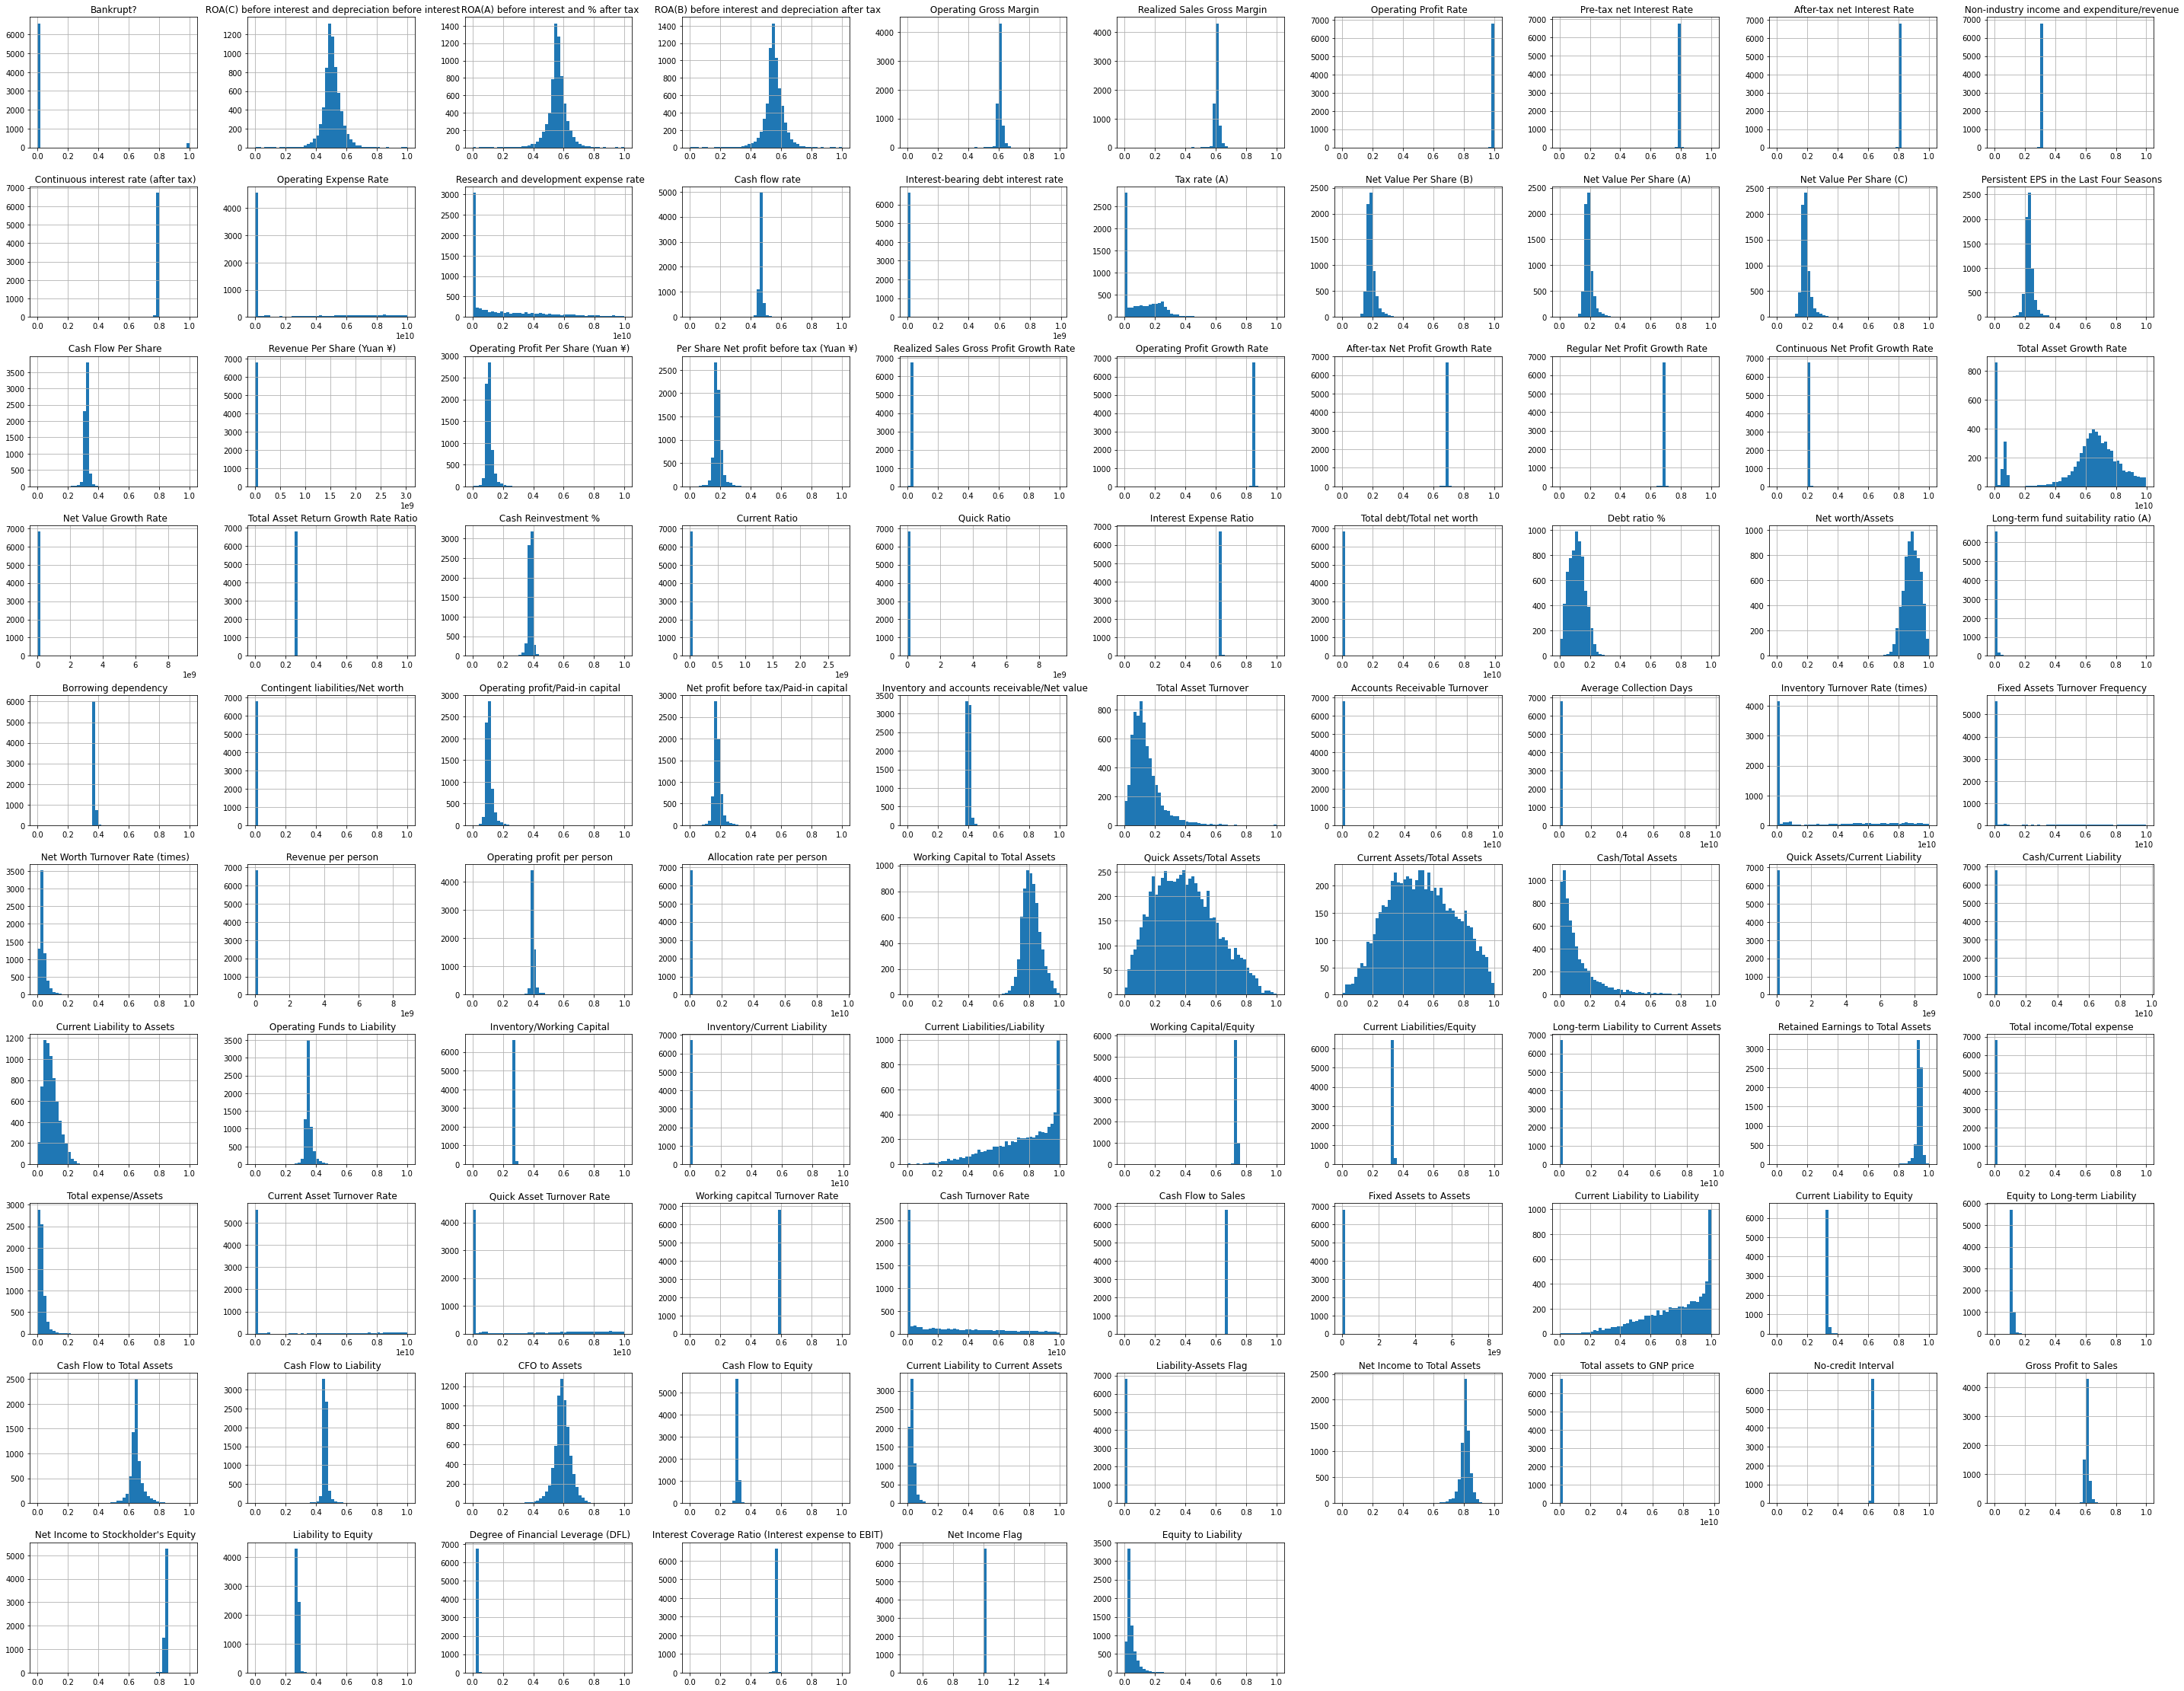

In [17]:
df.hist( bins = 50, figsize = (50, 40))
plt.show()

Text(0.5, 1.0, 'All variables boxplot\n')

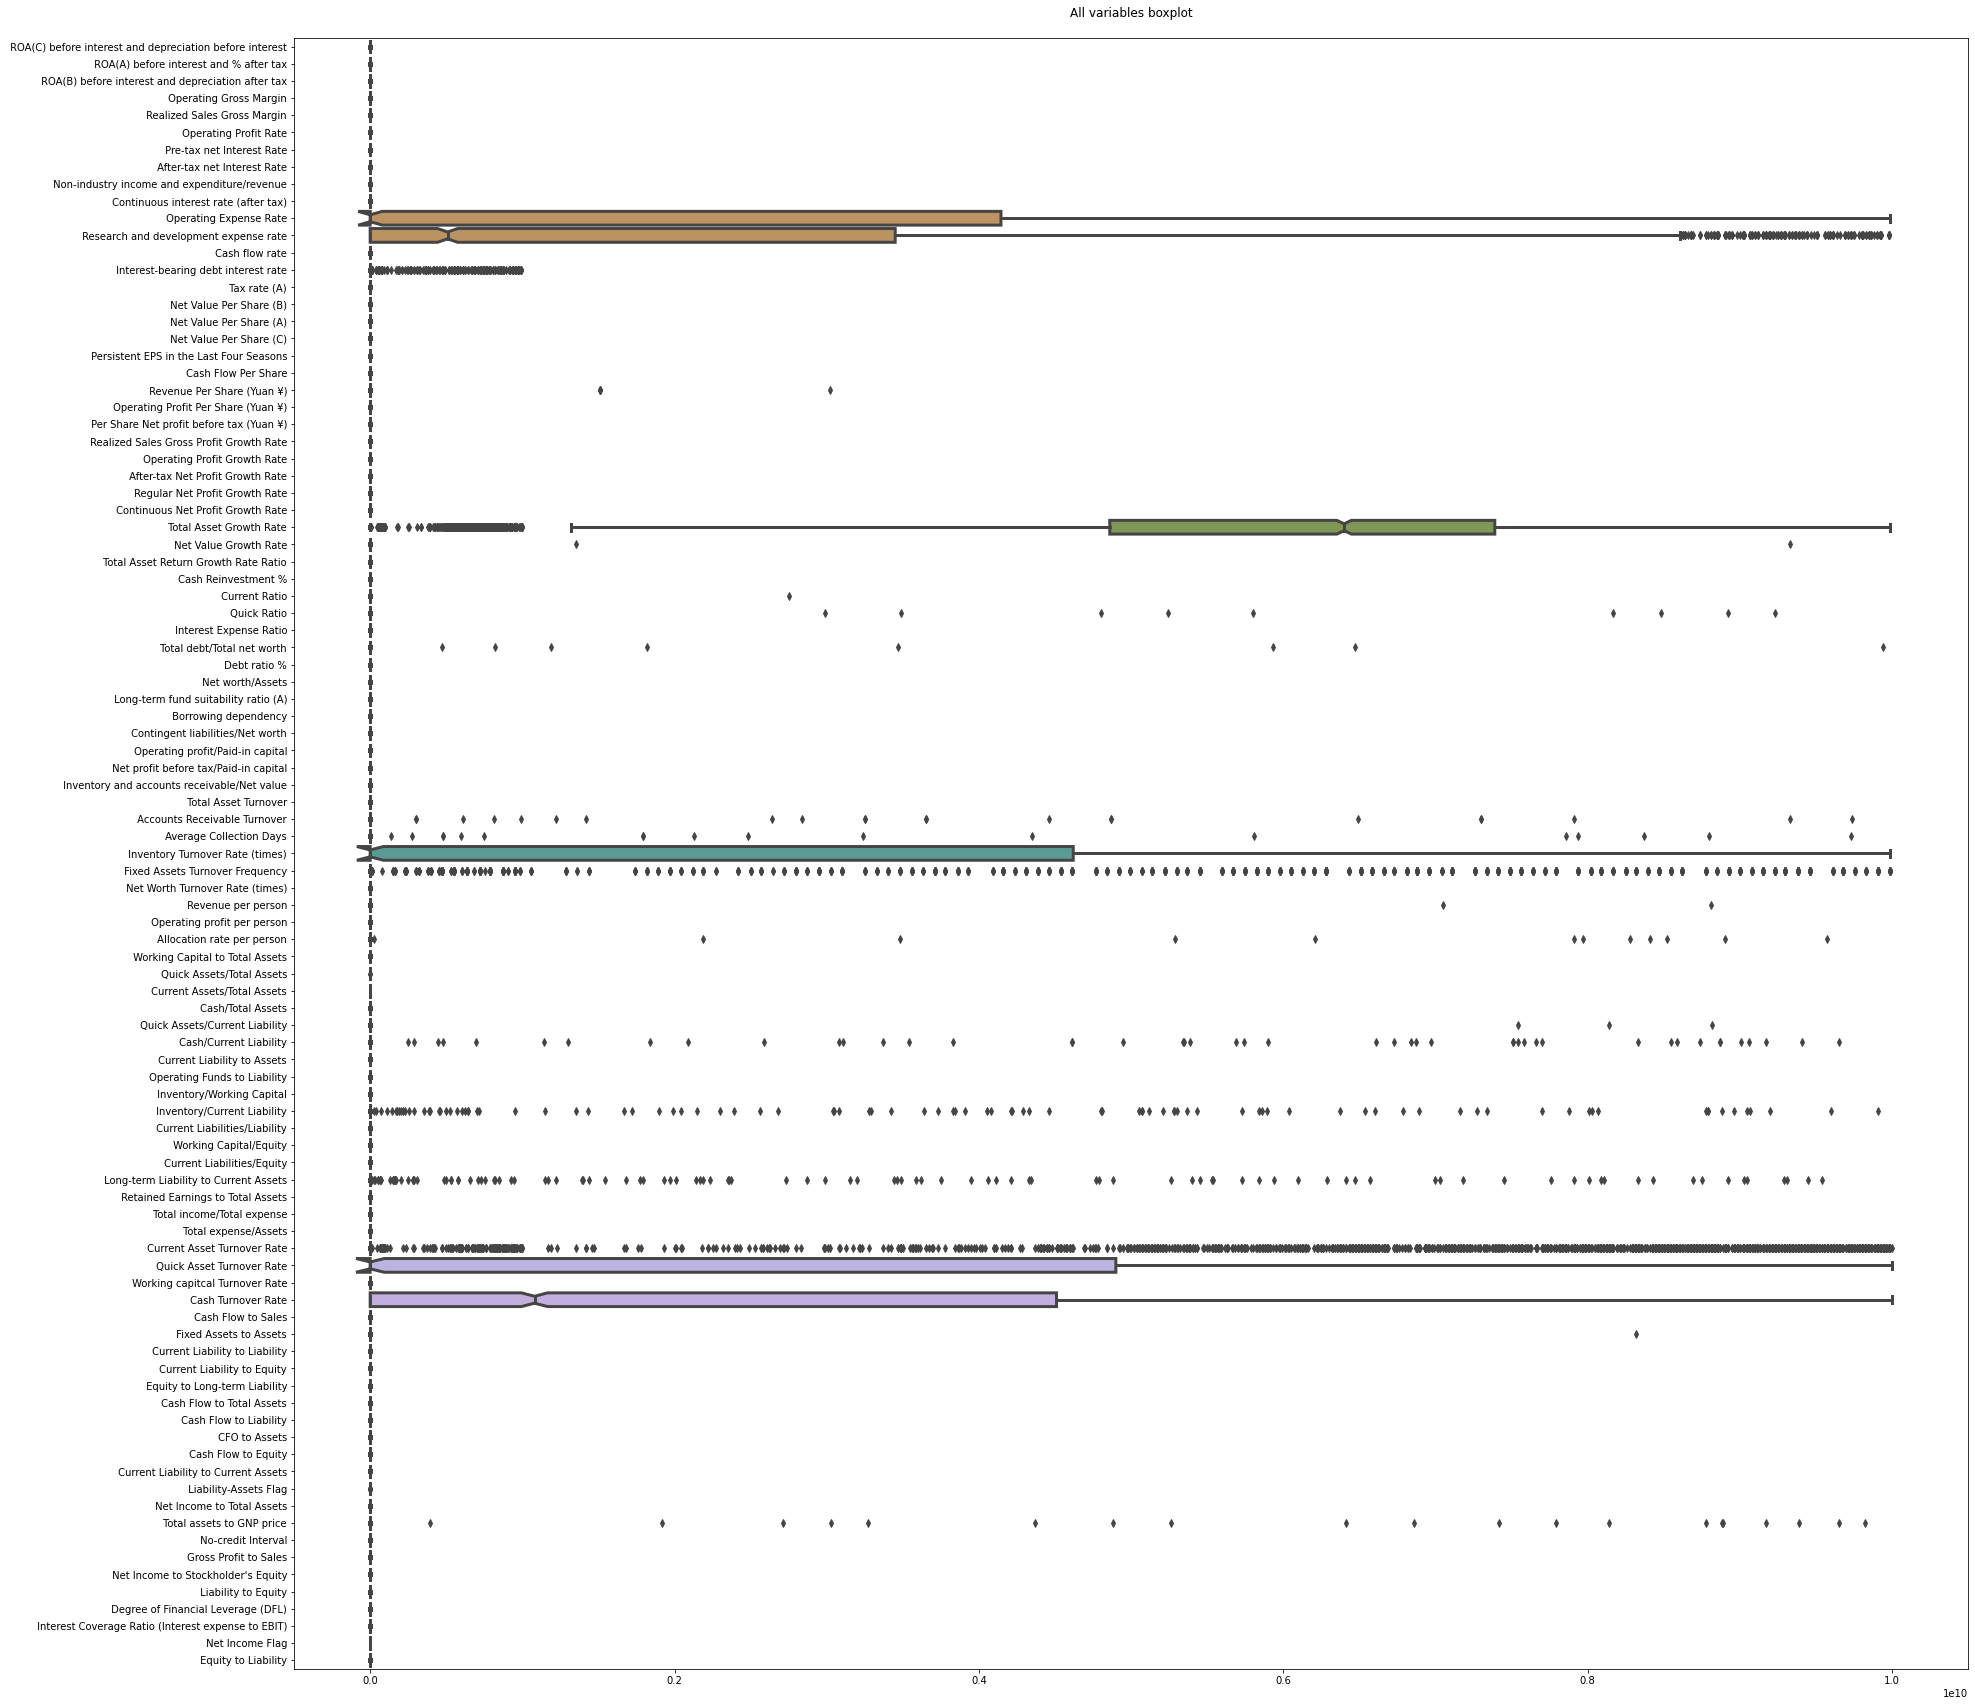

In [18]:
# Quick visual check for outliers:

fig = plt.figure(figsize=(30,30))
ax = fig.gca()

ax = sns.boxplot(data=df.loc[:, df.columns != 'Bankrupt?'], orient='h', fliersize=5, linewidth=3, notch=True,
                 saturation=0.5, ax=ax)

ax.set_title('All variables boxplot\n')

Based off the histograms and box plots above it looks like there are certain dimensions that contain outliers that might need to be investigated and addressed further.

##### Outliers

In [19]:
df.shape

(6819, 96)

In [20]:
# IQR Method
q1 = df.quantile(q=.25)
q3 = df.quantile(q=.75)
iqr = df.apply(stats.iqr)

df_iqr = df[~((df < (q1-1.5*iqr)) | (df > (q3+1.5*iqr))).any(axis=1)]

df_iqr.shape

(457, 96)

The IQR method of handling outliers above seems too harsh and removed most of the records from the dataset, thus might not the best solution.

In [21]:
# z-score Method: remove rows from df where z-scores are greater than absolute value of 3
cols = [col for col in df.columns if col != 'Bankrupt?']
df_z = df.copy()
for col in cols:
    col_zscore = col + '_zscore'
    df_z[col_zscore] = (df_z[col] - df_z[col].mean())/df_z[col].std(ddof=0)

In [22]:
zcols = [col for col in df_z.columns if '_zscore' in col]
for col in zcols:
  idx = df_z[(abs(df_z[col]) > 3)].index
  df_z = df_z.drop(idx)

df_z = df_z.drop(zcols, axis=1)
df_z.shape

(4909, 96)

In [23]:
df = df_z

Text(0.5, 1.0, 'All variables boxplot\n')

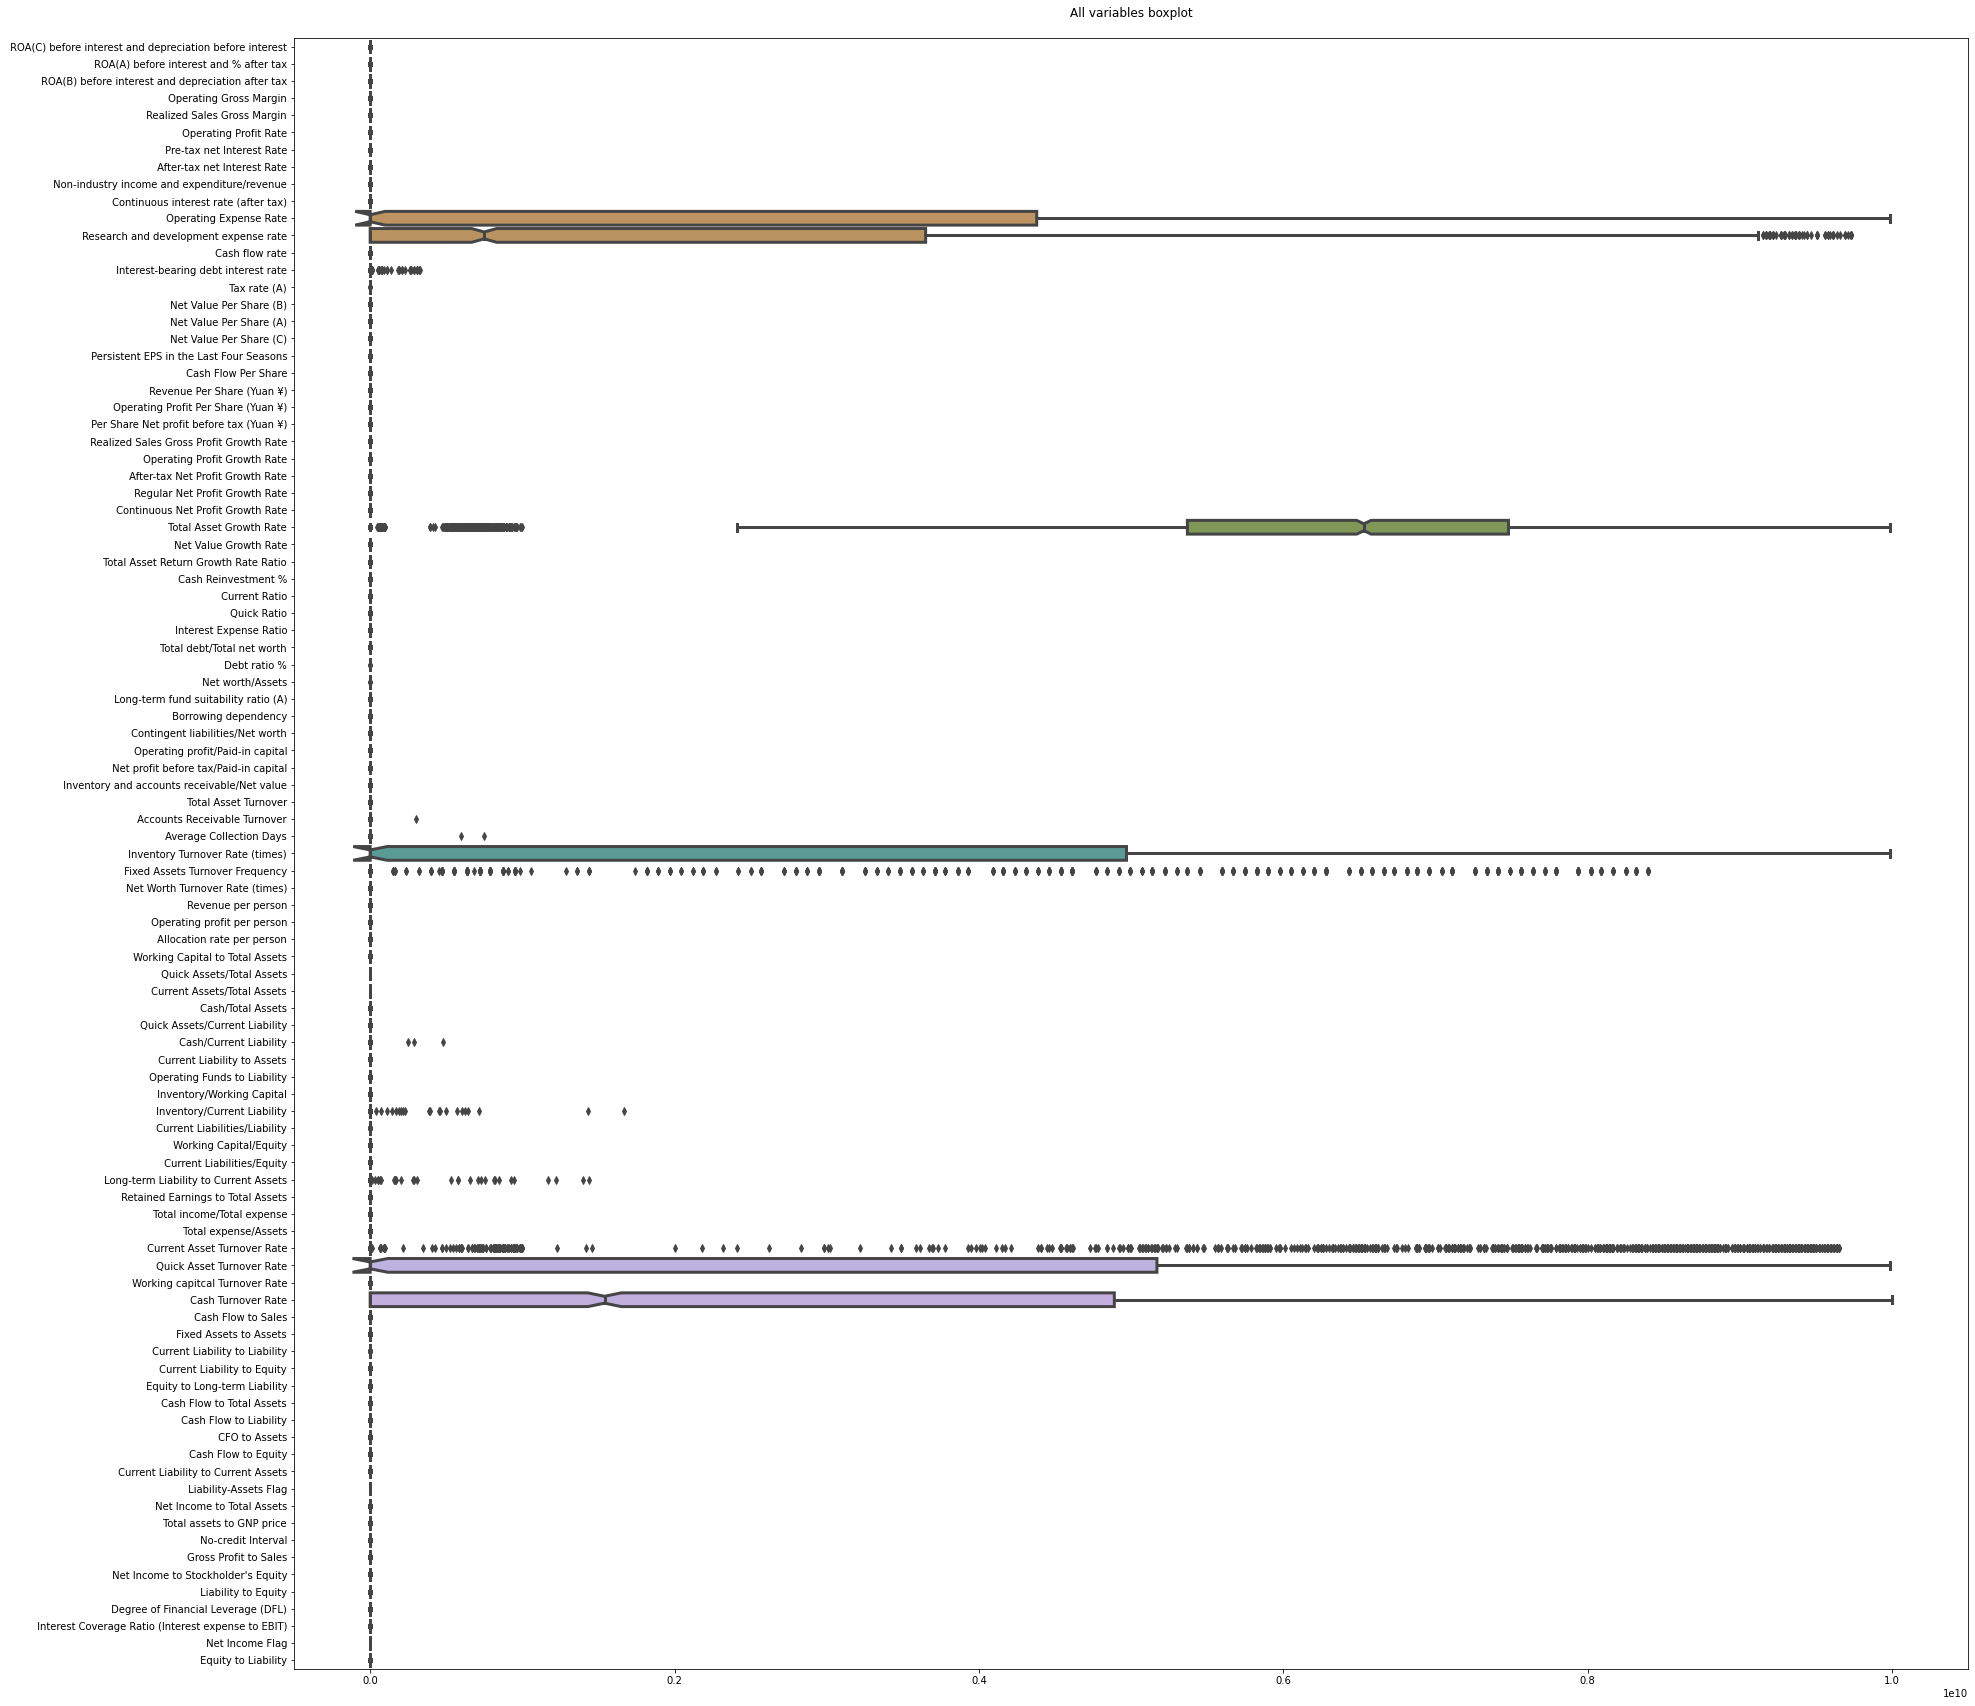

In [24]:
# Check boxplots
fig = plt.figure(figsize=(30,30))
ax = fig.gca()

ax = sns.boxplot(data=df_z.loc[:, df.columns != 'Bankrupt?'], orient='h', fliersize=5, linewidth=3, notch=True,
                 saturation=0.5, ax=ax)

ax.set_title('All variables boxplot\n')

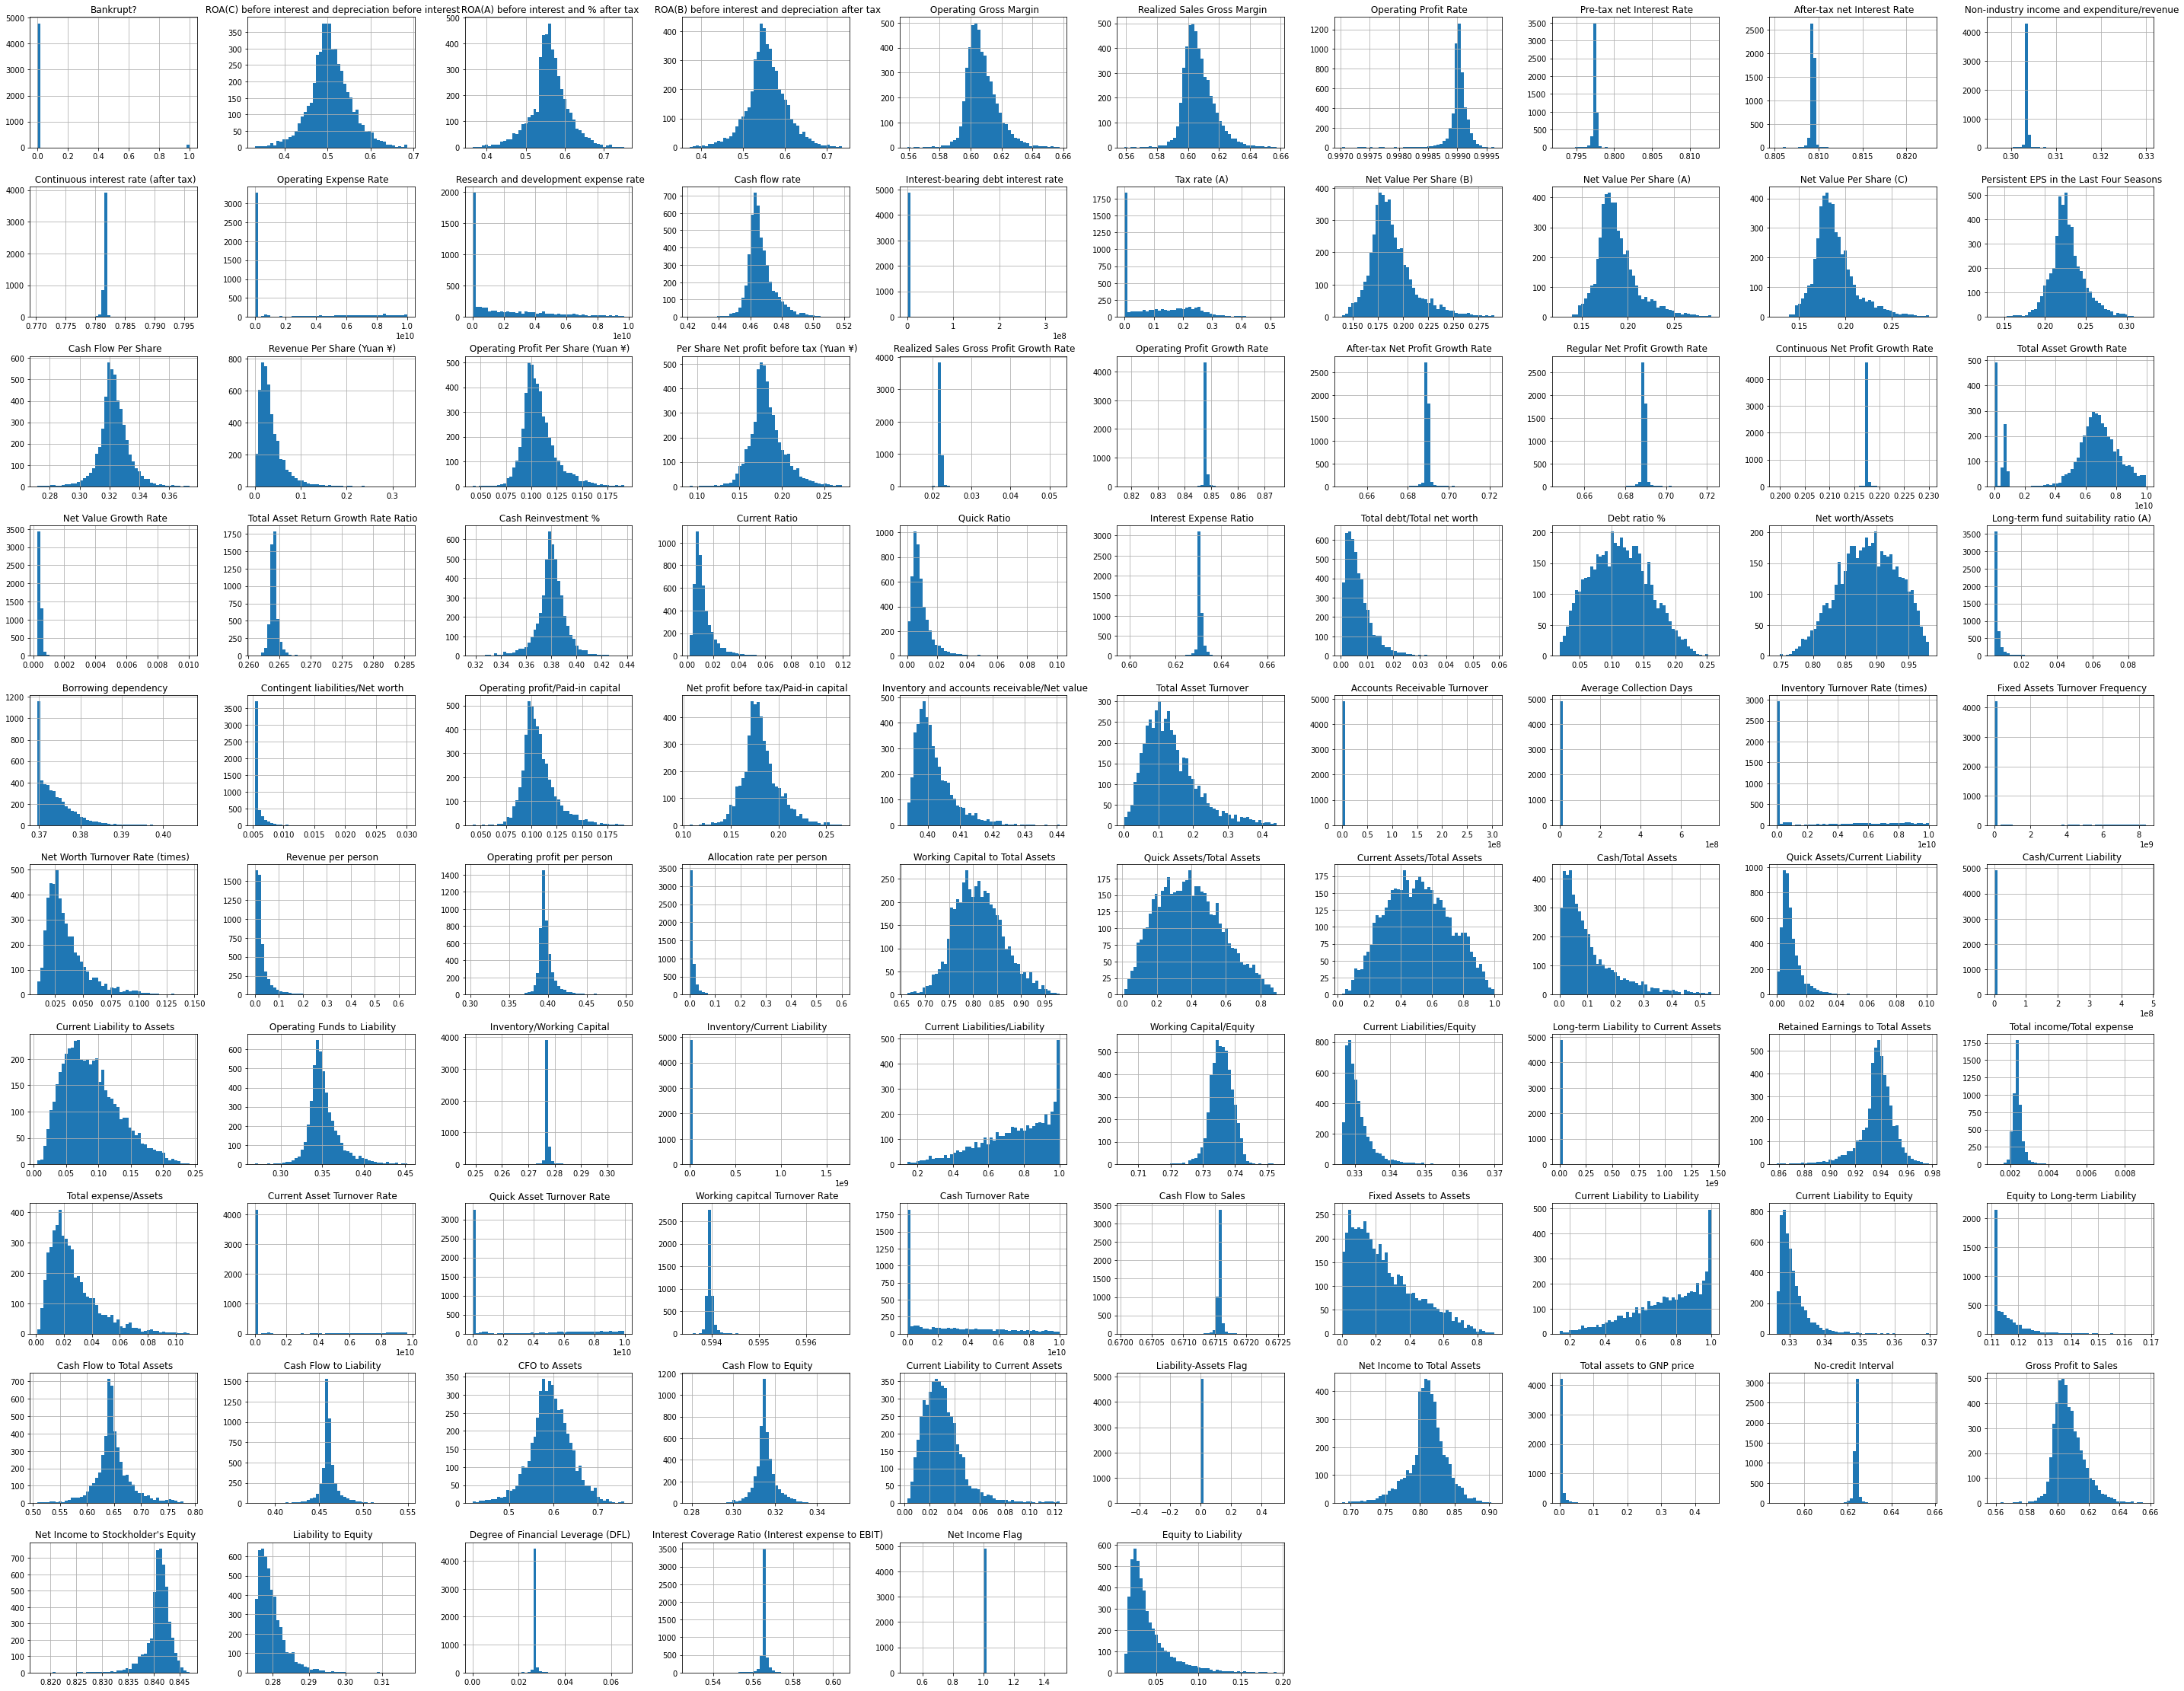

In [25]:
# Check dist
df.hist( bins = 50, figsize = (50, 40))
plt.show()

Using z-scores seems like a more effective method, given the distributions of the features above.

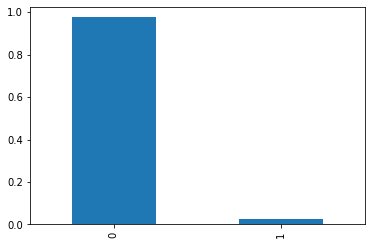

In [26]:
# Check Classes
df['Bankrupt?'].value_counts(normalize=True).plot(kind='bar')

In [27]:
df['Bankrupt?'].value_counts()

0    4790
1     119
Name: Bankrupt?, dtype: int64

It seems as though the dataset is quite imbalanced between bankrupt and non-bankrupt companies, and thus oversampling will be required to balance out the class.

#### Oversampling

In [28]:
x = df[cols]
y = df['Bankrupt?']

##### Resampling

In [29]:
x_train, x_test_up, y_train, y_test_up = train_test_split(x, y, test_size=0.2, stratify = y)
X = pd.concat([x_train, y_train], axis=1)
df_maj = X[X['Bankrupt?'] == 0]
df_min = X[X['Bankrupt?'] == 1]
df_min_upsample = resample(df_min, replace=True, n_samples=len(df_maj)) 
df_upsample = pd.concat([df_min_upsample, df_maj])

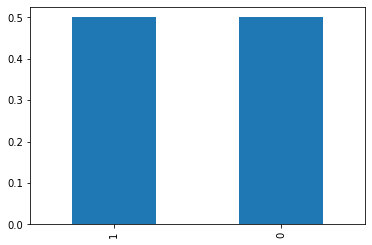

In [30]:
df_upsample['Bankrupt?'].value_counts(normalize=True).plot(kind='bar')

In [31]:
x_train_up = df_upsample[cols]
y_train_up = df_upsample['Bankrupt?']

Resampling can cause a model to overfit given the duplicate data that is fed in. SMOTE on the other hand, creates synthetic examples rather than sampling existing data, which can be beneficial in this scenario given how small the minority class is. 

##### SMOTE

1 : 0.4166666666666667
2 : 0.375
3 : 0.375
4 : 0.4583333333333333
5 : 0.375
6 : 0.375
7 : 0.375
8 : 0.375
9 : 0.375
10 : 0.375
11 : 0.4166666666666667
12 : 0.4166666666666667
13 : 0.375
14 : 0.375
15 : 0.375
16 : 0.4166666666666667
17 : 0.4166666666666667
18 : 0.375
19 : 0.375


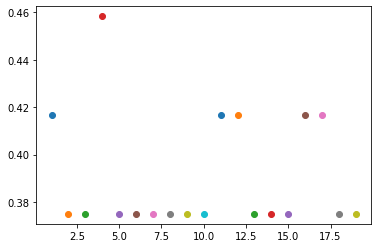

In [32]:
# Evalute using recall score of minority class.
logreg = LogisticRegression()

# SMOTE x/y train test split
x_train_sm, x_test_sm, y_train_sm, y_test_sm = train_test_split(x, y, test_size=0.2, stratify = y)
recalls = []
for k in range(1,20):
    sm = SMOTE(k_neighbors=k)
    x_smote, y_smote = sm.fit_resample(x_train_sm, y_train_sm)
    logreg.fit(x_smote,y_smote)
    smote_predict = logreg.predict(x_test_sm)
    recall = recall_score(y_test_sm, smote_predict)
    recalls.append((k, recall))
    print (k, ':', recall)
    plt.scatter(k, recall)

In [33]:
k = max(recalls, key=itemgetter(1))[0]
sm = SMOTE(k_neighbors=k)
x_train_sm, y_train_sm = sm.fit_resample(x_train_sm, y_train_sm)

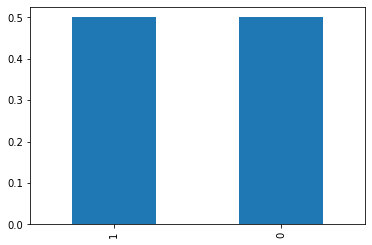

In [34]:
y_train_sm.value_counts(normalize=True).plot(kind='bar')

#### Modeling

Resample: *x_train_up, x_test_up, y_train_up, y_test_up*

SMOTE: x_train_sm, x_test_sm, y_train_sm, y_test_sm

In [35]:
cols1 = [col for col in x.columns if 'Flag' not in col]

In [36]:
def roc_auc(predict_proba, y):
  # Generate False positive rate and True positive rate
  fpr, tpr, _ = roc_curve(y, predict_proba)
  roc_auc = auc(fpr, tpr)

  # Plot 
  plt.figure()

  line_weight = 2
  plt.plot(fpr, tpr, color="darkorange", lw = line_weight, label = "ROC Curve %0.2f" % roc_auc)

  plt.plot([0, 1], [0, 1], color="navy", lw = line_weight, linestyle="--")
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC')
  plt.legend(loc="lower right")
  plt.show()

##### Logistic Regression - Resampling

In [37]:
steps = [('scaler', StandardScaler()),
         ('select', SelectKBest(f_classif, k=15)),
         ('logreg', LogisticRegression(penalty='l1', max_iter=10000))
         ]

pipe = Pipeline(steps)

grid_params = {
    'logreg__C': np.logspace(-4, 4, 75),
    'logreg__solver': ['saga', 'liblinear']
}

kf = StratifiedKFold(n_splits=7)
grid_1 = GridSearchCV(pipe, grid_params, cv=kf, verbose=1)

In [39]:
path = './drive/MyDrive/Colab Notebooks/MSDS422/'

pickle_in = open(path + 'grid_1.pickle', 'rb')
grid_1 = pickle.load(pickle_in)

In [40]:
# grid_1.fit(x_train_up[cols1], y_train_up)

In [41]:
grid_1.best_score_

0.8965290125466429

In [42]:
grid_1.best_params_

{'logreg__C': 0.0306539529505653, 'logreg__solver': 'liblinear'}

In [43]:
grid_1.score(x_test_up[cols1], y_test_up)

0.8737270875763747

In [44]:
pred_proba1 = grid_1.predict_proba(x_test_up[cols1])

In [45]:
preds_1 = grid_1.predict(x_test_up[cols1])

pred_1 = pd.DataFrame(x_test_up[cols1])
pred_1["target"] = y_test_up
pred_1["predictions"] = preds_1
pred_1.head()

,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Cash Flow Per Share,Revenue Per Share (Yuan ¥),Operating Profit Per Share (Yuan ¥),Per Share Net profit before tax (Yuan ¥),Realized Sales Gross Profit Growth Rate,Operating Profit Growth Rate,After-tax Net Profit Growth Rate,Regular Net Profit Growth Rate,Continuous Net Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Total Asset Return Growth Rate Ratio,Cash Reinvestment %,Current Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,Debt ratio %,Net worth/Assets,Long-term fund suitability ratio (A),Borrowing dependency,...,Current Assets/Total Assets,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Current Liability to Assets,Operating Funds to Liability,Inventory/Working Capital,Inventory/Current Liability,Current Liabilities/Liability,Working Capital/Equity,Current Liabilities/Equity,Long-term Liability to Current Assets,Retained Earnings to Total Assets,Total income/Total expense,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Working capitcal Turnover Rate,Cash Turnover Rate,Cash Flow to Sales,Fixed Assets to Assets,Current Liability to Liability,Current Liability to Equity,Equity to Long-term Liability,Cash Flow to Total Assets,Cash Flow to Liability,CFO to Assets,Cash Flow to Equity,Current Liability to Current Assets,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Equity to Liability,target,predictions
1976,0.429240,0.459496,0.468173,0.603208,0.602790,0.998918,0.797150,0.809088,0.303213,0.781327,1.986635e-04,1.061159e-04,0.460576,0.000410,0.000000,0.158316,0.158316,0.158316,0.193911,0.316085,0.019420,0.091279,0.153875,0.022046,0.847850,0.687276,0.687276,0.217383,8.390000e+09,0.000391,0.262713,0.373142,0.008197,0.007130,0.630476,0.011517,0.165190,0.834810,0.005146,0.373517,...,0.653781,0.037361,0.007347,0.001334,0.148469,0.338563,0.277194,0.002550,0.856266,0.736397,0.335020,0.002279,0.918520,0.002085,0.045704,0.000241,0.000227,0.593961,3.750000e+08,0.671575,0.324026,0.856266,0.335020,0.114097,0.645976,0.459746,0.553454,0.315207,0.035440,0.757126,0.000703,0.623950,0.603207,0.835982,0.283131,0.026750,0.564954,0.021688,0,1
5841,0.570273,0.620366,0.614755,0.611129,0.611129,0.999178,0.797889,0.809722,0.303962,0.782012,7.230000e+09,0.000000e+00,0.473493,0.000171,0.135742,0.202688,0.202688,0.202688,0.250922,0.332602,0.018271,0.113672,0.204640,0.022143,0.848093,0.689688,0.689688,0.217626,7.330000e+09,0.000533,0.264647,0.392832,0.006598,0.006220,0.630674,0.003183,0.076246,0.923754,0.006157,0.371671,...,0.246820,0.047933,0.006155,0.003617,0.070002,0.371705,0.277415,0.001500,0.851931,0.732283,0.328672,0.000000,0.949621,0.003331,0.007642,0.000131,0.000131,0.593924,7.180000e+09,0.671557,0.146142,0.851931,0.328672,0.110933,0.630081,0.455094,0.643281,0.312948,0.043724,0.845241,0.003122,0.623500,0.611124,0.843126,0.277087,0.026808,0.565237,0.050465,0,0
6144,0.490323,0.540122,0.539376,0.613399,0.613399,0.999046,0.797435,0.809340,0.303443,0.781660,2.405239e-04,4.330000e+09,0.468257,0.000410,0.361271,0.188951,0.188951,0.188951,0.222653,0.321072,0.019239,0.102842,0.173533,0.022061,0.848008,0.689209,0.689209,0.217588,4.620000e+09,0.000424,0.263712,0.378088,0.030035,0.022509,0.631037,0.001715,0.046

In [46]:
#Confusion Matrix
cm1 = confusion_matrix(pred_1["target"], pred_1["predictions"], labels=[1,0]
                       )

cm1_df = pd.DataFrame(cm1, columns = ["Predicted Bankrupt", "Predicted Not Bankrupt"], index = ["Actual Bankrupt", "Actual Not Bankrupt"])
cm1_df

,Predicted Bankrupt,Predicted Not Bankrupt
Actual Bankrupt,19,5
Actual Not Bankrupt,119,839


In [47]:
target_name = ['0', '1']
print(classification_report(pred_1['target'], pred_1['predictions'], target_names=target_name))

              precision    recall  f1-score   support

           0       0.99      0.88      0.93       958
           1       0.14      0.79      0.23        24

    accuracy                           0.87       982
   macro avg       0.57      0.83      0.58       982
weighted avg       0.97      0.87      0.91       982



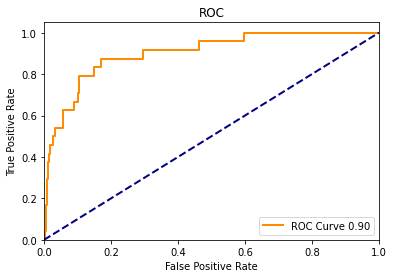

In [48]:
roc_auc(pred_proba1[:,1], y_test_up)

For a baseline logistic regression model, it seems to perform relatively well, though the precision of predicting bankruptcy is quite low at 14%. The ROC AUC tells us that the model is quite successful at distinguishing between the two classes, although it seems that the model is slightly overfit to the training data given the resampling of the minority class. Resampling duplicates the datapoints and thus can lead to overfitting to the duplicate data.

In [49]:
# Pickle model
# path = './drive/MyDrive/Colab Notebooks/MSDS422/'

# pickle_out = open(path + 'grid_1.pickle', 'wb')
# pickle.dump(grid_1, pickle_out)
# pickle_out.close()

##### Logistic Regression - SMOTE

In [50]:
steps = [('scaler', StandardScaler()),
         ('select', SelectKBest(f_classif, k=15)),
         ('logreg', LogisticRegression(penalty='l1', max_iter=10000))
         ]

pipe = Pipeline(steps)

grid_params = {
    'logreg__C': np.logspace(-4, 4, 75),
    'logreg__solver': ['saga', 'liblinear']
}

kf = StratifiedKFold(n_splits=7)
grid_2 = GridSearchCV(pipe, grid_params, cv=kf, verbose=1)

In [51]:
pickle_in = open(path + 'grid_2.pickle', 'rb')
grid_2 = pickle.load(pickle_in)

In [52]:
# grid_2.fit(x_train_sm[cols1], y_train_sm)

In [53]:
grid_2.best_score_

0.8927491589658828

In [54]:
grid_2.best_params_

{'logreg__C': 0.06468607661546327, 'logreg__solver': 'saga'}

In [55]:
grid_2.score(x_test_sm[cols1], y_test_sm)

0.895112016293279

In [56]:
pred_proba2 = grid_2.predict_proba(x_test_sm[cols1])

In [57]:
preds_2 = grid_2.predict(x_test_sm[cols1])

pred_2 = pd.DataFrame(x_test_sm[cols1])
pred_2["target"] = y_test_sm
pred_2["predictions"] = preds_2
pred_2.head()

,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Cash Flow Per Share,Revenue Per Share (Yuan ¥),Operating Profit Per Share (Yuan ¥),Per Share Net profit before tax (Yuan ¥),Realized Sales Gross Profit Growth Rate,Operating Profit Growth Rate,After-tax Net Profit Growth Rate,Regular Net Profit Growth Rate,Continuous Net Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Total Asset Return Growth Rate Ratio,Cash Reinvestment %,Current Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,Debt ratio %,Net worth/Assets,Long-term fund suitability ratio (A),Borrowing dependency,...,Current Assets/Total Assets,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Current Liability to Assets,Operating Funds to Liability,Inventory/Working Capital,Inventory/Current Liability,Current Liabilities/Liability,Working Capital/Equity,Current Liabilities/Equity,Long-term Liability to Current Assets,Retained Earnings to Total Assets,Total income/Total expense,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Working capitcal Turnover Rate,Cash Turnover Rate,Cash Flow to Sales,Fixed Assets to Assets,Current Liability to Liability,Current Liability to Equity,Equity to Long-term Liability,Cash Flow to Total Assets,Cash Flow to Liability,CFO to Assets,Cash Flow to Equity,Current Liability to Current Assets,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Equity to Liability,target,predictions
1220,0.484961,0.549444,0.535896,0.600110,0.600110,0.999003,0.797432,0.809346,0.303528,0.781601,7.070000e+09,0.000000e+00,0.462189,0.000490,0.195364,0.190847,0.190847,0.190847,0.220384,0.318880,0.036693,0.102353,0.176772,0.022116,0.848061,0.689362,0.689362,0.217588,7.120000e+08,0.000454,0.263935,0.374753,0.010105,0.005109,0.631519,0.006962,0.127914,0.872086,0.005205,0.373576,...,0.472353,0.005902,0.005069,0.000356,0.087772,0.342221,0.277597,0.013352,0.646289,0.735737,0.330260,0.001347,0.934856,0.002317,0.016640,0.000137,7.050000e+09,0.593956,4.860000e+08,0.671572,0.342189,0.646289,0.330260,0.111992,0.642645,0.459218,0.571105,0.314520,0.028889,0.804418,0.014923,0.623567,0.600108,0.840732,0.279829,0.027071,0.566214,0.029038,0,0
522,0.512066,0.550262,0.555115,0.619179,0.619179,0.999109,0.797513,0.809400,0.303446,0.781666,2.696643e-04,1.161332e-04,0.474422,0.000249,0.258731,0.177068,0.177068,0.177068,0.219911,0.323230,0.012115,0.103575,0.175717,0.022108,0.848036,0.689515,0.689515,0.217607,6.530000e+09,0.000456,0.264067,0.383238,0.016640,0.010041,0.631156,0.003747,0.085860,0.914140,0.005083,0.373115,...,0.316999,0.111098,0.011272,0.016123,0.036168,0.356177,0.277233,0.014205,0.386965,0.735181,0.327526,0.017504,0.935082,0.002304,0.024240,0.000182,1.298304e-04,0.594000,1.756098e-04,0.671591,0.686215,0.386965,0.327526,0.118391,0.658271,0.463735,0.608611,0.316587,0.017630,0.806412,0.000823,0.624017,0.619179,0.840725,0.277496,0.026883,0.565563,0.044620,0,0
1453,0.580510,0.625164,0.626425,0.610545,0.610163,0.999177,0.797676,0.809556,0.303590,0.781832,5.760000e+09,1.190000e+09,0.467267,0.000395,0.105375,0.197674,0.197674,0.197674,0.244587,0.321744,0.025243,0.120593,0.196807,0.022356,0.848342,0.689798,0.689798,0.217646,9.310000e+09,0.000507,0.265051,0.381683,0.016559,0.009864,0.630667,0.00218

In [58]:
#Confusion Matrix
cm2 = confusion_matrix(pred_2["target"], pred_2["predictions"], labels=[1,0]
                       )

cm2_df = pd.DataFrame(cm2, columns = ["Predicted Bankrupt", "Predicted Not Bankrupt"], index = ["Actual Bankrupt", "Actual Not Bankrupt"])
cm2_df

,Predicted Bankrupt,Predicted Not Bankrupt
Actual Bankrupt,18,6
Actual Not Bankrupt,97,861


In [59]:
target_name = ['0', '1']
print(classification_report(pred_2['target'], pred_2['predictions'], target_names=target_name))

              precision    recall  f1-score   support

           0       0.99      0.90      0.94       958
           1       0.16      0.75      0.26        24

    accuracy                           0.90       982
   macro avg       0.57      0.82      0.60       982
weighted avg       0.97      0.90      0.93       982



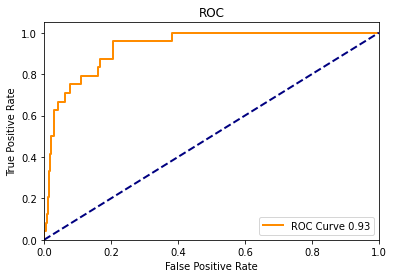

In [60]:
roc_auc(pred_proba2[:,1], y_test_sm)

In [61]:
# Pickle model

# pickle_out = open(path + 'grid_2.pickle', 'wb')
# pickle.dump(grid_2, pickle_out)
# pickle_out.close()

It seems as though fitting the logistic regression with oversampled data using SMOTE improved the model quite a bit, in terms of the ROC AUC. It seems like the recall of predicting the bankrupt class is slightly lower than the previous, but overall a better fit model that handles unseen data better.

##### Naïve Bayes - Resampling

In [62]:
steps = [('scaler', StandardScaler()),
         ('select', SelectKBest(f_classif, k=15)),
         ('nb', GaussianNB())
         ]

pipe = Pipeline(steps)

grid_params = {
    'nb__var_smoothing': np.logspace(-9, 2, 100)
}

kf = StratifiedKFold(n_splits=7)
grid_3 = GridSearchCV(pipe, grid_params, cv=kf, verbose=1)

In [63]:
# Read in Pickled model

pickle_in = open(path + 'grid_3.pickle', 'rb')
grid_3 = pickle.load(pickle_in)

In [64]:
# grid_3.fit(x_train_up[cols1], y_train_up)

In [65]:
grid_3.best_score_

0.8802187344598005

In [66]:
grid_3.best_params_

{'nb__var_smoothing': 0.001}

In [67]:
grid_3.score(x_test_up[cols1], y_test_up)

0.869653767820774

In [68]:
pred_proba3 = grid_3.predict_proba(x_test_up[cols1])

In [69]:
preds_3 = grid_3.predict(x_test_up[cols1])

pred_3 = pd.DataFrame(x_test_up[cols1])
pred_3["target"] = y_test_up
pred_3["predictions"] = preds_3
pred_3.head()

,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Cash Flow Per Share,Revenue Per Share (Yuan ¥),Operating Profit Per Share (Yuan ¥),Per Share Net profit before tax (Yuan ¥),Realized Sales Gross Profit Growth Rate,Operating Profit Growth Rate,After-tax Net Profit Growth Rate,Regular Net Profit Growth Rate,Continuous Net Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Total Asset Return Growth Rate Ratio,Cash Reinvestment %,Current Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,Debt ratio %,Net worth/Assets,Long-term fund suitability ratio (A),Borrowing dependency,...,Current Assets/Total Assets,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Current Liability to Assets,Operating Funds to Liability,Inventory/Working Capital,Inventory/Current Liability,Current Liabilities/Liability,Working Capital/Equity,Current Liabilities/Equity,Long-term Liability to Current Assets,Retained Earnings to Total Assets,Total income/Total expense,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Working capitcal Turnover Rate,Cash Turnover Rate,Cash Flow to Sales,Fixed Assets to Assets,Current Liability to Liability,Current Liability to Equity,Equity to Long-term Liability,Cash Flow to Total Assets,Cash Flow to Liability,CFO to Assets,Cash Flow to Equity,Current Liability to Current Assets,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Equity to Liability,target,predictions
1976,0.429240,0.459496,0.468173,0.603208,0.602790,0.998918,0.797150,0.809088,0.303213,0.781327,1.986635e-04,1.061159e-04,0.460576,0.000410,0.000000,0.158316,0.158316,0.158316,0.193911,0.316085,0.019420,0.091279,0.153875,0.022046,0.847850,0.687276,0.687276,0.217383,8.390000e+09,0.000391,0.262713,0.373142,0.008197,0.007130,0.630476,0.011517,0.165190,0.834810,0.005146,0.373517,...,0.653781,0.037361,0.007347,0.001334,0.148469,0.338563,0.277194,0.002550,0.856266,0.736397,0.335020,0.002279,0.918520,0.002085,0.045704,0.000241,0.000227,0.593961,3.750000e+08,0.671575,0.324026,0.856266,0.335020,0.114097,0.645976,0.459746,0.553454,0.315207,0.035440,0.757126,0.000703,0.623950,0.603207,0.835982,0.283131,0.026750,0.564954,0.021688,0,1
5841,0.570273,0.620366,0.614755,0.611129,0.611129,0.999178,0.797889,0.809722,0.303962,0.782012,7.230000e+09,0.000000e+00,0.473493,0.000171,0.135742,0.202688,0.202688,0.202688,0.250922,0.332602,0.018271,0.113672,0.204640,0.022143,0.848093,0.689688,0.689688,0.217626,7.330000e+09,0.000533,0.264647,0.392832,0.006598,0.006220,0.630674,0.003183,0.076246,0.923754,0.006157,0.371671,...,0.246820,0.047933,0.006155,0.003617,0.070002,0.371705,0.277415,0.001500,0.851931,0.732283,0.328672,0.000000,0.949621,0.003331,0.007642,0.000131,0.000131,0.593924,7.180000e+09,0.671557,0.146142,0.851931,0.328672,0.110933,0.630081,0.455094,0.643281,0.312948,0.043724,0.845241,0.003122,0.623500,0.611124,0.843126,0.277087,0.026808,0.565237,0.050465,0,0
6144,0.490323,0.540122,0.539376,0.613399,0.613399,0.999046,0.797435,0.809340,0.303443,0.781660,2.405239e-04,4.330000e+09,0.468257,0.000410,0.361271,0.188951,0.188951,0.188951,0.222653,0.321072,0.019239,0.102842,0.173533,0.022061,0.848008,0.689209,0.689209,0.217588,4.620000e+09,0.000424,0.263712,0.378088,0.030035,0.022509,0.631037,0.001715,0.046

In [70]:
#Confusion Matrix
cm3 = confusion_matrix(pred_3["target"], pred_3["predictions"], labels=[1,0]
                       )

cm3_df = pd.DataFrame(cm3, columns = ["Predicted Bankrupt", "Predicted Not Bankrupt"], index = ["Actual Bankrupt", "Actual Not Bankrupt"])
cm3_df

,Predicted Bankrupt,Predicted Not Bankrupt
Actual Bankrupt,16,8
Actual Not Bankrupt,120,838


In [71]:
target_name = ['0', '1']
print(classification_report(pred_3['target'], pred_3['predictions'], target_names=target_name))

              precision    recall  f1-score   support

           0       0.99      0.87      0.93       958
           1       0.12      0.67      0.20        24

    accuracy                           0.87       982
   macro avg       0.55      0.77      0.56       982
weighted avg       0.97      0.87      0.91       982



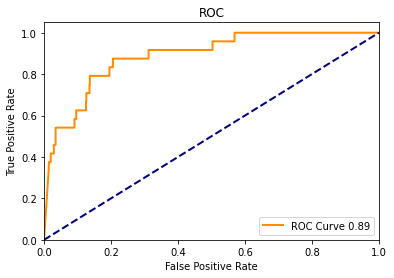

In [72]:
roc_auc(pred_proba3[:,1], y_test_up)

In [73]:
# Pickle model

# pickle_out = open(path + 'grid_3.pickle', 'wb')
# pickle.dump(grid_3, pickle_out)
# pickle_out.close()

The naive Bayes model seems to have performed worse overall compared to the previous two models. One thing to note is that a prior was not passed as a model parameter and I wonder if passing one could improve the model. Could be something to play around with in the next iteration.

##### Naïve Bayes - SMOTE

In [74]:
steps = [('scaler', StandardScaler()),
         ('select', SelectKBest(f_classif, k=15)),
         ('nb', GaussianNB())
         ]

pipe = Pipeline(steps)

grid_params = {
    'nb__var_smoothing': np.logspace(-9, 2, 100)
}

kf = StratifiedKFold(n_splits=7)
grid_4 = GridSearchCV(pipe, grid_params, cv=kf, verbose=1)

In [75]:
pickle_in = open(path + 'grid_4.pickle', 'rb')
grid_4 = pickle.load(pickle_in)

In [76]:
# grid_4.fit(x_train_sm[cols1], y_train_sm)

In [77]:
grid_4.best_score_

0.8816580029121663

In [78]:
grid_4.best_params_

{'nb__var_smoothing': 0.012915496650148827}

In [79]:
grid_4.score(x_test_sm[cols1], y_test_sm)

0.8757637474541752

In [80]:
pred_proba4 = grid_4.predict_proba(x_test_sm[cols1])

In [81]:
preds_4 = grid_4.predict(x_test_sm[cols1])

pred_4 = pd.DataFrame(x_test_sm[cols1])
pred_4["target"] = y_test_sm
pred_4["predictions"] = preds_4
pred_4.head()

,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Cash Flow Per Share,Revenue Per Share (Yuan ¥),Operating Profit Per Share (Yuan ¥),Per Share Net profit before tax (Yuan ¥),Realized Sales Gross Profit Growth Rate,Operating Profit Growth Rate,After-tax Net Profit Growth Rate,Regular Net Profit Growth Rate,Continuous Net Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Total Asset Return Growth Rate Ratio,Cash Reinvestment %,Current Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,Debt ratio %,Net worth/Assets,Long-term fund suitability ratio (A),Borrowing dependency,...,Current Assets/Total Assets,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Current Liability to Assets,Operating Funds to Liability,Inventory/Working Capital,Inventory/Current Liability,Current Liabilities/Liability,Working Capital/Equity,Current Liabilities/Equity,Long-term Liability to Current Assets,Retained Earnings to Total Assets,Total income/Total expense,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Working capitcal Turnover Rate,Cash Turnover Rate,Cash Flow to Sales,Fixed Assets to Assets,Current Liability to Liability,Current Liability to Equity,Equity to Long-term Liability,Cash Flow to Total Assets,Cash Flow to Liability,CFO to Assets,Cash Flow to Equity,Current Liability to Current Assets,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Equity to Liability,target,predictions
1220,0.484961,0.549444,0.535896,0.600110,0.600110,0.999003,0.797432,0.809346,0.303528,0.781601,7.070000e+09,0.000000e+00,0.462189,0.000490,0.195364,0.190847,0.190847,0.190847,0.220384,0.318880,0.036693,0.102353,0.176772,0.022116,0.848061,0.689362,0.689362,0.217588,7.120000e+08,0.000454,0.263935,0.374753,0.010105,0.005109,0.631519,0.006962,0.127914,0.872086,0.005205,0.373576,...,0.472353,0.005902,0.005069,0.000356,0.087772,0.342221,0.277597,0.013352,0.646289,0.735737,0.330260,0.001347,0.934856,0.002317,0.016640,0.000137,7.050000e+09,0.593956,4.860000e+08,0.671572,0.342189,0.646289,0.330260,0.111992,0.642645,0.459218,0.571105,0.314520,0.028889,0.804418,0.014923,0.623567,0.600108,0.840732,0.279829,0.027071,0.566214,0.029038,0,0
522,0.512066,0.550262,0.555115,0.619179,0.619179,0.999109,0.797513,0.809400,0.303446,0.781666,2.696643e-04,1.161332e-04,0.474422,0.000249,0.258731,0.177068,0.177068,0.177068,0.219911,0.323230,0.012115,0.103575,0.175717,0.022108,0.848036,0.689515,0.689515,0.217607,6.530000e+09,0.000456,0.264067,0.383238,0.016640,0.010041,0.631156,0.003747,0.085860,0.914140,0.005083,0.373115,...,0.316999,0.111098,0.011272,0.016123,0.036168,0.356177,0.277233,0.014205,0.386965,0.735181,0.327526,0.017504,0.935082,0.002304,0.024240,0.000182,1.298304e-04,0.594000,1.756098e-04,0.671591,0.686215,0.386965,0.327526,0.118391,0.658271,0.463735,0.608611,0.316587,0.017630,0.806412,0.000823,0.624017,0.619179,0.840725,0.277496,0.026883,0.565563,0.044620,0,0
1453,0.580510,0.625164,0.626425,0.610545,0.610163,0.999177,0.797676,0.809556,0.303590,0.781832,5.760000e+09,1.190000e+09,0.467267,0.000395,0.105375,0.197674,0.197674,0.197674,0.244587,0.321744,0.025243,0.120593,0.196807,0.022356,0.848342,0.689798,0.689798,0.217646,9.310000e+09,0.000507,0.265051,0.381683,0.016559,0.009864,0.630667,0.00218

In [82]:
#Confusion Matrix
cm4 = confusion_matrix(pred_4["target"], pred_4["predictions"], labels=[1,0]
                       )

cm4_df = pd.DataFrame(cm4, columns = ["Predicted Bankrupt", "Predicted Not Bankrupt"], index = ["Actual Bankrupt", "Actual Not Bankrupt"])
cm4_df

,Predicted Bankrupt,Predicted Not Bankrupt
Actual Bankrupt,17,7
Actual Not Bankrupt,115,843


In [83]:
target_name = ['0', '1']
print(classification_report(pred_4['target'], pred_4['predictions'], target_names=target_name))

              precision    recall  f1-score   support

           0       0.99      0.88      0.93       958
           1       0.13      0.71      0.22        24

    accuracy                           0.88       982
   macro avg       0.56      0.79      0.58       982
weighted avg       0.97      0.88      0.92       982



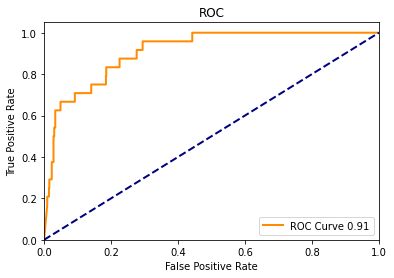

In [84]:
roc_auc(pred_proba4[:,1], y_test_sm)

In [85]:
# Pickle model

# pickle_out = open(path + 'grid_4.pickle', 'wb')
# pickle.dump(grid_4, pickle_out)
# pickle_out.close()

Again utilizing SMOTE improves the model over standard resampling, although the naive Bayes model still has not performed better than tried and true logistic regression. Two things that come to mind are whether passing a prior into the model would improve its performance, and whether determining SMOTE's optimal k neighbors using logistic regression introduced a bias towards logistic regression. We can investigate in next iterations of modeling.

##### SVM - Resampling

In [89]:
steps = [('scaler', StandardScaler()),
         ('select', SelectKBest(f_classif, k=15)),
         ('svc', svm.SVC(probability=True))
         ]

pipe = Pipeline(steps)

grid_params = {
    'svc__C': np.logspace(-8, 2, 30),
    'svc__kernel': ['rbf', 'sigmoid'],
    'svc__gamma': [0.0001, 0.001],
}

kf = StratifiedKFold(n_splits=5)
grid_5 = GridSearchCV(pipe, grid_params, cv=kf, verbose=1)

In [90]:
pickle_in = open(path + 'grid_5.pickle', 'rb')
grid_5 = pickle.load(pickle_in)

In [91]:
# grid_5.fit(x_train_up[cols1], y_train_up)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('select', SelectKBest(k=15)),
                                       ('svc', SVC(probability=True))]),
             param_grid={'svc__C': array([1.00000000e-08, 2.21221629e-08, 4.89390092e-08, 1.08263673e-07,
       2.39502662e-07, 5.29831691e-07, 1.17210230e-06, 2.59294380e-06,
       5.73615251e...42e-05,
       1.37382380e-04, 3.03919538e-04, 6.72335754e-04, 1.48735211e-03,
       3.29034456e-03, 7.27895384e-03, 1.61026203e-02, 3.56224789e-02,
       7.88046282e-02, 1.74332882e-01, 3.85662042e-01, 8.53167852e-01,
       1.88739182e+00, 4.17531894e+00, 9.23670857e+00, 2.04335972e+01,
       4.52035366e+01, 1.00000000e+02]),
                         'svc__gamma': [0.0001, 0.001],
                         'svc__kernel': ['rbf', 'sigmoid']},
             verbose=1)

In [92]:
grid_5.best_score_

0.8804788133644674

In [93]:
grid_5.best_params_

{'svc__C': 100.0, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}

In [94]:
grid_5.score(x_test_up[cols1], y_test_up)

0.8513238289205702

In [95]:
pred_proba5 = grid_5.predict_proba(x_test_up[cols1])

In [96]:
preds_5 = grid_5.predict(x_test_up[cols1])

pred_5 = pd.DataFrame(x_test_up[cols1])
pred_5["target"] = y_test_up
pred_5["predictions"] = preds_5
pred_5.head()

,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Cash Flow Per Share,Revenue Per Share (Yuan ¥),Operating Profit Per Share (Yuan ¥),Per Share Net profit before tax (Yuan ¥),Realized Sales Gross Profit Growth Rate,Operating Profit Growth Rate,After-tax Net Profit Growth Rate,Regular Net Profit Growth Rate,Continuous Net Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Total Asset Return Growth Rate Ratio,Cash Reinvestment %,Current Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,Debt ratio %,Net worth/Assets,Long-term fund suitability ratio (A),Borrowing dependency,...,Current Assets/Total Assets,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Current Liability to Assets,Operating Funds to Liability,Inventory/Working Capital,Inventory/Current Liability,Current Liabilities/Liability,Working Capital/Equity,Current Liabilities/Equity,Long-term Liability to Current Assets,Retained Earnings to Total Assets,Total income/Total expense,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Working capitcal Turnover Rate,Cash Turnover Rate,Cash Flow to Sales,Fixed Assets to Assets,Current Liability to Liability,Current Liability to Equity,Equity to Long-term Liability,Cash Flow to Total Assets,Cash Flow to Liability,CFO to Assets,Cash Flow to Equity,Current Liability to Current Assets,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Equity to Liability,target,predictions
1976,0.429240,0.459496,0.468173,0.603208,0.602790,0.998918,0.797150,0.809088,0.303213,0.781327,1.986635e-04,1.061159e-04,0.460576,0.000410,0.000000,0.158316,0.158316,0.158316,0.193911,0.316085,0.019420,0.091279,0.153875,0.022046,0.847850,0.687276,0.687276,0.217383,8.390000e+09,0.000391,0.262713,0.373142,0.008197,0.007130,0.630476,0.011517,0.165190,0.834810,0.005146,0.373517,...,0.653781,0.037361,0.007347,0.001334,0.148469,0.338563,0.277194,0.002550,0.856266,0.736397,0.335020,0.002279,0.918520,0.002085,0.045704,0.000241,0.000227,0.593961,3.750000e+08,0.671575,0.324026,0.856266,0.335020,0.114097,0.645976,0.459746,0.553454,0.315207,0.035440,0.757126,0.000703,0.623950,0.603207,0.835982,0.283131,0.026750,0.564954,0.021688,0,0
5841,0.570273,0.620366,0.614755,0.611129,0.611129,0.999178,0.797889,0.809722,0.303962,0.782012,7.230000e+09,0.000000e+00,0.473493,0.000171,0.135742,0.202688,0.202688,0.202688,0.250922,0.332602,0.018271,0.113672,0.204640,0.022143,0.848093,0.689688,0.689688,0.217626,7.330000e+09,0.000533,0.264647,0.392832,0.006598,0.006220,0.630674,0.003183,0.076246,0.923754,0.006157,0.371671,...,0.246820,0.047933,0.006155,0.003617,0.070002,0.371705,0.277415,0.001500,0.851931,0.732283,0.328672,0.000000,0.949621,0.003331,0.007642,0.000131,0.000131,0.593924,7.180000e+09,0.671557,0.146142,0.851931,0.328672,0.110933,0.630081,0.455094,0.643281,0.312948,0.043724,0.845241,0.003122,0.623500,0.611124,0.843126,0.277087,0.026808,0.565237,0.050465,0,0
6144,0.490323,0.540122,0.539376,0.613399,0.613399,0.999046,0.797435,0.809340,0.303443,0.781660,2.405239e-04,4.330000e+09,0.468257,0.000410,0.361271,0.188951,0.188951,0.188951,0.222653,0.321072,0.019239,0.102842,0.173533,0.022061,0.848008,0.689209,0.689209,0.217588,4.620000e+09,0.000424,0.263712,0.378088,0.030035,0.022509,0.631037,0.001715,0.046

In [97]:
#Confusion Matrix
cm5 = confusion_matrix(pred_5["target"], pred_5["predictions"], labels=[1,0]
                       )

cm5_df = pd.DataFrame(cm5, columns = ["Predicted Bankrupt", "Predicted Not Bankrupt"], index = ["Actual Bankrupt", "Actual Not Bankrupt"])
cm5_df

,Predicted Bankrupt,Predicted Not Bankrupt
Actual Bankrupt,20,4
Actual Not Bankrupt,142,816


In [98]:
target_name = ['0', '1']
print(classification_report(pred_5['target'], pred_5['predictions'], target_names=target_name))

              precision    recall  f1-score   support

           0       1.00      0.85      0.92       958
           1       0.12      0.83      0.22        24

    accuracy                           0.85       982
   macro avg       0.56      0.84      0.57       982
weighted avg       0.97      0.85      0.90       982



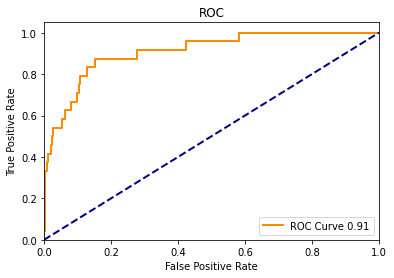

In [99]:
roc_auc(pred_proba5[:,1], y_test_up)

In [100]:
# Pickle model

# pickle_out = open(path + 'grid_5.pickle', 'wb')
# pickle.dump(grid_5, pickle_out)
# pickle_out.close()

The SVM model fitting and hyperparameter tuning took quite some time, and to alleviate this (to a certain extent), certain variations for parameters were removed. It's possible that because of this, a non optimal model was fit. It's interesting that the rbf kernel seemed to have performed better than the sigmoid given it generally performs well with circular/spherical data. The "optimal" C value of 100 suggests a more flexible boundary between the classes, which combined with resampling would cause the model to be overfit, although the ROC AUC suggest that it performs on par with the previous models fit.

##### SVM - SMOTE

In [101]:
steps = [('scaler', StandardScaler()),
         ('select', SelectKBest(f_classif, k=15)),
         ('svc', svm.SVC(probability=True))
         ]

pipe = Pipeline(steps)

grid_params = {
    'svc__C': np.logspace(-8, 2, 30),
    'svc__kernel': ['rbf', 'sigmoid'],
    'svc__gamma': [0.0001, 0.001],
}

kf = StratifiedKFold(n_splits=5)
grid_6 = GridSearchCV(pipe, grid_params, cv=kf, verbose=1)

In [102]:
pickle_in = open(path + 'grid_6.pickle', 'rb')
grid_6 = pickle.load(pickle_in)

In [103]:
# grid_6.fit(x_train_sm[cols1], y_train_sm)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('select', SelectKBest(k=15)),
                                       ('svc', SVC(probability=True))]),
             param_grid={'svc__C': array([1.00000000e-08, 2.21221629e-08, 4.89390092e-08, 1.08263673e-07,
       2.39502662e-07, 5.29831691e-07, 1.17210230e-06, 2.59294380e-06,
       5.73615251e...42e-05,
       1.37382380e-04, 3.03919538e-04, 6.72335754e-04, 1.48735211e-03,
       3.29034456e-03, 7.27895384e-03, 1.61026203e-02, 3.56224789e-02,
       7.88046282e-02, 1.74332882e-01, 3.85662042e-01, 8.53167852e-01,
       1.88739182e+00, 4.17531894e+00, 9.23670857e+00, 2.04335972e+01,
       4.52035366e+01, 1.00000000e+02]),
                         'svc__gamma': [0.0001, 0.001],
                         'svc__kernel': ['rbf', 'sigmoid']},
             verbose=1)

In [104]:
grid_6.best_score_

0.9119276695978294

In [105]:
grid_6.best_params_

{'svc__C': 100.0, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}

In [106]:
grid_6.score(x_test_sm[cols1], y_test_sm)

0.8961303462321792

In [107]:
pred_proba6 = grid_6.predict_proba(x_test_sm[cols1])

In [108]:
preds_6 = grid_6.predict(x_test_sm[cols1])

pred_6 = pd.DataFrame(x_test_sm[cols1])
pred_6["target"] = y_test_sm
pred_6["predictions"] = preds_6
pred_6.head()

,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Cash Flow Per Share,Revenue Per Share (Yuan ¥),Operating Profit Per Share (Yuan ¥),Per Share Net profit before tax (Yuan ¥),Realized Sales Gross Profit Growth Rate,Operating Profit Growth Rate,After-tax Net Profit Growth Rate,Regular Net Profit Growth Rate,Continuous Net Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Total Asset Return Growth Rate Ratio,Cash Reinvestment %,Current Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,Debt ratio %,Net worth/Assets,Long-term fund suitability ratio (A),Borrowing dependency,...,Current Assets/Total Assets,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Current Liability to Assets,Operating Funds to Liability,Inventory/Working Capital,Inventory/Current Liability,Current Liabilities/Liability,Working Capital/Equity,Current Liabilities/Equity,Long-term Liability to Current Assets,Retained Earnings to Total Assets,Total income/Total expense,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Working capitcal Turnover Rate,Cash Turnover Rate,Cash Flow to Sales,Fixed Assets to Assets,Current Liability to Liability,Current Liability to Equity,Equity to Long-term Liability,Cash Flow to Total Assets,Cash Flow to Liability,CFO to Assets,Cash Flow to Equity,Current Liability to Current Assets,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Equity to Liability,target,predictions
1220,0.484961,0.549444,0.535896,0.600110,0.600110,0.999003,0.797432,0.809346,0.303528,0.781601,7.070000e+09,0.000000e+00,0.462189,0.000490,0.195364,0.190847,0.190847,0.190847,0.220384,0.318880,0.036693,0.102353,0.176772,0.022116,0.848061,0.689362,0.689362,0.217588,7.120000e+08,0.000454,0.263935,0.374753,0.010105,0.005109,0.631519,0.006962,0.127914,0.872086,0.005205,0.373576,...,0.472353,0.005902,0.005069,0.000356,0.087772,0.342221,0.277597,0.013352,0.646289,0.735737,0.330260,0.001347,0.934856,0.002317,0.016640,0.000137,7.050000e+09,0.593956,4.860000e+08,0.671572,0.342189,0.646289,0.330260,0.111992,0.642645,0.459218,0.571105,0.314520,0.028889,0.804418,0.014923,0.623567,0.600108,0.840732,0.279829,0.027071,0.566214,0.029038,0,0
522,0.512066,0.550262,0.555115,0.619179,0.619179,0.999109,0.797513,0.809400,0.303446,0.781666,2.696643e-04,1.161332e-04,0.474422,0.000249,0.258731,0.177068,0.177068,0.177068,0.219911,0.323230,0.012115,0.103575,0.175717,0.022108,0.848036,0.689515,0.689515,0.217607,6.530000e+09,0.000456,0.264067,0.383238,0.016640,0.010041,0.631156,0.003747,0.085860,0.914140,0.005083,0.373115,...,0.316999,0.111098,0.011272,0.016123,0.036168,0.356177,0.277233,0.014205,0.386965,0.735181,0.327526,0.017504,0.935082,0.002304,0.024240,0.000182,1.298304e-04,0.594000,1.756098e-04,0.671591,0.686215,0.386965,0.327526,0.118391,0.658271,0.463735,0.608611,0.316587,0.017630,0.806412,0.000823,0.624017,0.619179,0.840725,0.277496,0.026883,0.565563,0.044620,0,0
1453,0.580510,0.625164,0.626425,0.610545,0.610163,0.999177,0.797676,0.809556,0.303590,0.781832,5.760000e+09,1.190000e+09,0.467267,0.000395,0.105375,0.197674,0.197674,0.197674,0.244587,0.321744,0.025243,0.120593,0.196807,0.022356,0.848342,0.689798,0.689798,0.217646,9.310000e+09,0.000507,0.265051,0.381683,0.016559,0.009864,0.630667,0.00218

In [109]:
#Confusion Matrix
cm6 = confusion_matrix(pred_6["target"], pred_6["predictions"], labels=[1,0]
                       )

cm6_df = pd.DataFrame(cm6, columns = ["Predicted Bankrupt", "Predicted Not Bankrupt"], index = ["Actual Bankrupt", "Actual Not Bankrupt"])
cm6_df

,Predicted Bankrupt,Predicted Not Bankrupt
Actual Bankrupt,16,8
Actual Not Bankrupt,94,864


In [110]:
target_name = ['0', '1']
print(classification_report(pred_6['target'], pred_6['predictions'], target_names=target_name))

              precision    recall  f1-score   support

           0       0.99      0.90      0.94       958
           1       0.15      0.67      0.24        24

    accuracy                           0.90       982
   macro avg       0.57      0.78      0.59       982
weighted avg       0.97      0.90      0.93       982



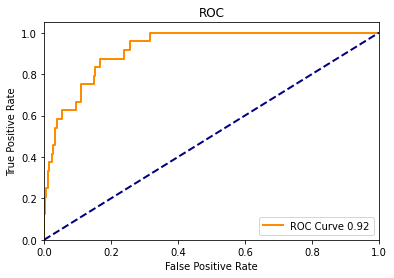

In [111]:
roc_auc(pred_proba6[:,1], y_test_sm)

In [112]:
# Pickle model

# pickle_out = open(path + 'grid_6.pickle', 'wb')
# pickle.dump(grid_6, pickle_out)
# pickle_out.close()

The hyperparameters for this model is identical to the previous. I wonder whether additional parameters and variations would yield different results between the two. Again, it seems as though SMOTE performs better than resampling which was the cause of the overfitting of the previous model. The SVM model did not perform better than the logistic regression with SMOTE, and I once again wonder if it's because the optimal k was set using a logistic regression. 